Note to self: This notebook isn't finished. I need to add more on the energy-preserving integration. Specifically find the approximated H that gives the scheme we are using.

# Solving the Camssa–Holm equation numerically

In [1]:
import autograd.numpy as np
from autograd import elementwise_grad
import numpy.linalg as la
from scipy.sparse import spdiags

import matplotlib.pyplot as plt
colors = [(0,0.4,1),(1,0.7,0.3),(0.2,0.7,0.2),(0.8,0,0.2),(0.5,0.3,.9)]

## The Camassa–Holm equation

In this notebook, we consider the one-dimensional (damped and forced) Camassa–Holm (CH) equation. It is given by
\begin{equation}
u_t  - u_{xxt} + \kappa u_x + 3 u u_x - 2 u_x u_{xx} - u u_{xxx} = g(x,t).
\label{eq:kdv} \tag{1}
\end{equation}
If $g(x,t) = 0$, we have the standard, i.e. unforced, Camassa–Holm equation equation. If $\kappa > 0$, we have smooth soliton solutions, and if $\kappa=0$ we gete peakon solutions.

For the standard Camassa–Holm equation, the energy given by
$$
\begin{align*}
\mathcal{H}[u] &= \frac{1}{2} \int_\mathbb{R} \left(u^3 + u u_x^2 + \kappa u^2\right)\, dx
\end{align*}
$$
is conserved, i.e. constant over time.

To get it on the standard form of a Hamiltonian PDE, we introduce the variable $m(x,t) := u(x,t) - u_{xx}(x,t) + \kappa$, and have that
$$
\begin{align*}
m_t &= S(x,m^J) \frac{\delta \mathcal{H}}{\delta m}
\end{align*}
$$
for $S(x,m^J) = -\partial_x + \partial_{xxx} = - (1 - \partial_{xx})\partial_x$, since
$$
\begin{align*}
\frac{\delta\mathcal{H}}{\delta m}[u] &= \frac{\delta u}{\delta m} \frac{\delta\mathcal{H}}{\delta u}[u] \\
& = (1-\partial_{xx})^{-1} (\frac{3}{2} u^2 - \frac{1}{2}u_x^2 - u u_{xx} + \kappa u).
\end{align*}
$$

That is,
\begin{equation}
u_t - u_{xxt} = - \frac{\partial}{\partial x} \left(\frac{3}{2} u^2 - \frac{1}{2}u_x^2 - u u_{xx} + \kappa u\right),
\label{eq:kdvmod} \tag{2}
\end{equation}
which we see is equivalent to (1) for $g(x,t) = 0$.

### Analytic solution
Exact peakon solutions can be derived analytically for the case $\kappa=0$. E.g., for the inital condition
$$
u(x,0) = c \, \frac{\mathrm{cosh} \left(\lvert x- \eta\rvert - P/2\right)}{\mathrm{cosh}(P/2)},
$$
and periodic boundary conditions $u(P,t) = u(0,t)$ for all $t\geq0$, the exact solution at all times is
$$
u(x,0) = c \, \frac{\mathrm{cosh} \left(\lvert (x - c t) \, \mathrm{mod} \, P  - \eta \rvert - P/2\right)}{\mathrm{cosh}(P/2)}.
$$

In [2]:
def grid(P=20, M=100):
    dx = P/M
    x = np.linspace(0, P-dx, M)
    return x, dx

In [3]:
c = 3 # the speed
P = 20 # period
eta = P/2 # initial peak position
M = 200 # number of spatial points
x, dx = grid(P, M)
u_soliton = lambda x, t: c*np.cosh(np.abs((x-c*t) % P - eta) - P/2)/np.cosh(P/2)

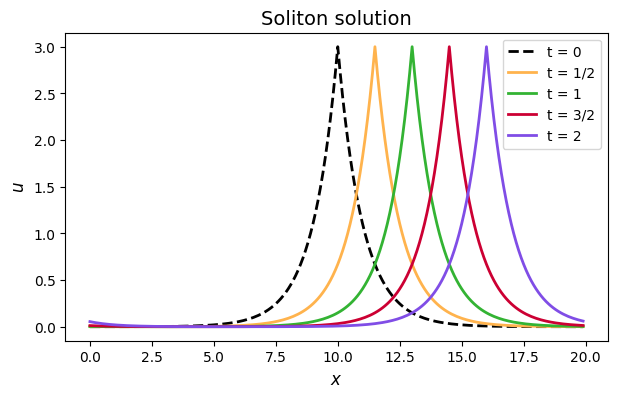

In [4]:
fig = plt.figure(figsize=(7,4))
lw = 2
plt.plot(x, u_soliton(x, 0), 'k--', linewidth=lw, label='t = 0')
plt.plot(x, u_soliton(x, 1/2), color = colors[1], linewidth=lw, label='t = 1/2')  
plt.plot(x, u_soliton(x, 1), color = colors[2], linewidth=lw, label='t = 1')  
plt.plot(x, u_soliton(x, 3/2), color = colors[3], linewidth=lw, label='t = 3/2')  
plt.plot(x, u_soliton(x, 2), color = colors[4], linewidth=lw, label='t = 2')  
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$u$', fontsize=12)
plt.title('Soliton solution', fontsize=14)
plt.legend()
plt.show()

Observe that the height of the wave and the speed is $3=c$.

## Discretizing in space

In [5]:
def difference_matrices(P=20, M=100):
    dx = P/M
    e = np.ones(M) # unit vector of length M
    # 1st order central difference matrix:
    D1 = .5/dx*spdiags([e,-e,e,-e], np.array([-M+1,-1,1,M-1]), M, M).toarray()
    # 2nd order central difference matrix:
    D2 = 1/dx**2*spdiags([e,e,-2*e,e,e], np.array([-M+1,-1,0,1,M-1]), M, M).toarray()
    return D1, D2

### Semi-discrete formulation as a system of ODEs

Using the difference operators to approximate the spatial derivatives of (2) with an additional forcing term, we get
\begin{equation}
(I-D_c^2)\mathbf{u}_t = - D_c^1 (\frac{3}{2} \mathbf{u}^2 - \frac{1}{2} (D_c^1\mathbf{u})^2 - \mathbf{u}(D_c^2\mathbf{u}) + \kappa \mathbf{u} ) + \mathbf{g}(t),
\label{eq:kdv_disc} \tag{3}
\end{equation}
where $I$ is the identity matrix and
\begin{align}
\mathbf{g}(t) = 
\begin{pmatrix}
    g(x_0,t) \\
    g(x_1,t) \\
    \vdots \\
    g(x_{M-1},t)
\end{pmatrix},
\end{align}
and multiplication between vectors is understood to be element-wise.

In [6]:
# At this point we need to decide on the grid that we want to use in the time-integration to follow:
P = 20
M = 400 # increase or decrease M to see how the approximation gets better/worse
x, dx = grid(P, M)
D1, D2 = difference_matrices(P,M)

In [7]:
# We must also define the system (1) by defining g and kappa:
g = lambda x, t: 0
kappa = 0

In [8]:
# Define f so that u_t = f is (3)
I = np.eye(M)
f = lambda u, t: np.linalg.solve(I-D2, -np.matmul(D1, 1.5*u**2 - .5*np.matmul(D1,u)**2
                                  - u*np.matmul(D2,u) + kappa*u) + g(x, t))

## Integration in time

For the semi-discretized Camassa–Holm equation, we have
$$
f(\mathbf{u}, t) = (I-D_c^2)^{-1} \left(- D_c^1 \big(\frac{3}{2} \mathbf{u}^2 - \frac{1}{2} (D_c^1\mathbf{u})^2 - \mathbf{u}(D_c^2\mathbf{u}) + \kappa \mathbf{u} \big) + \mathbf{g}(t)\right)
$$
and
$$
\frac{\partial}{\partial \mathbf{u}} f(\mathbf{u}, t) = - (I-D_c^2)^{-1} D_c^1 \left(3 \mathrm{diag}(\mathbf{u)} - \mathrm{diag}(D_c^1 \mathbf{u}) D_c^1 - \mathrm{diag}(D_c^2\mathbf{u}) - \mathrm{diag}(\mathbf{u})D_c^2 + \kappa I \right),
$$
where $\mathrm{diag}(\mathbf{u})$ is an $M \times M$ diagonal matrix with $\mathbf{u}$ on the diagonal.

In [9]:
u0 = u_soliton(x,0)
Df = lambda u: np.linalg.solve(I-D2, -np.matmul(D1, 3*np.diag(u) - np.matmul(np.diag(np.matmul(D1,u)),D1)
                 - np.diag(np.matmul(D2,u)) - np.matmul(np.diag(u),D2) + kappa*I))

In [10]:
def midpoint_method(u,un,t,f,Df,dt,M,tol,max_iter):
    '''
    Integrating one step of the ODE u_t = f, from u to un,
    with the implicit midpoint method
    Using Newton's method to find un
    '''
    I = np.eye(M)
    F = lambda u_hat: 1/dt*(u_hat-u) - f((u+u_hat)/2, t+.5*dt)
    J = lambda u_hat: 1/dt*I - 1/2*Df((u+u_hat)/2)
    err = la.norm(F(un))
    it = 0
    while err > tol:
        un = un - la.solve(J(un),F(un))
        err = la.norm(F(un))
        it += 1
        if it > max_iter:
            break
    return un

In [11]:
t_max = 2
N = 100
t, dt = grid(t_max, N)
u = np.zeros([t.shape[0], u0.shape[-1]])
u[0, :] = u0

In [12]:
# The implicit midpoint method:
for i, t_step in enumerate(t[:-1]):
    u[i+1,:] = midpoint_method(u[i,:], u[i,:], t[i], f, Df, dt, M, 1e-12, 5)

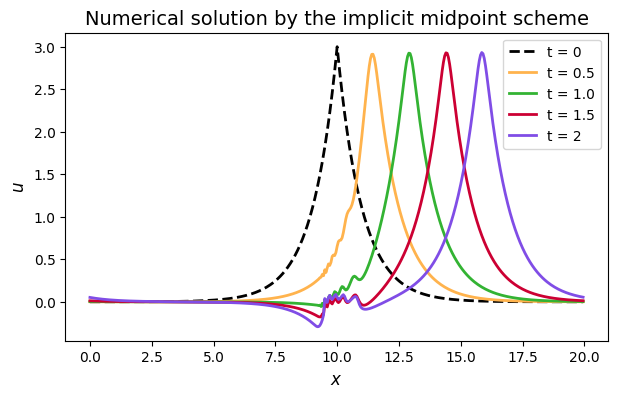

In [13]:
fig = plt.figure(figsize=(7,4))
lw = 2
plt.plot(x, u[0,:], 'k--', linewidth=lw, label='t = 0')
plt.plot(x, u[int(N/4),:], color = colors[1], linewidth=lw, label=f't = {1/4*t_max}')  
plt.plot(x, u[int(N/2),:], color = colors[2], linewidth=lw, label=f't = {1/2*t_max}')  
plt.plot(x, u[int(3*N/4),:], color = colors[3], linewidth=lw, label=f't = {3/4*t_max}')  
plt.plot(x, u[-1,:], color = colors[4], linewidth=lw, label=f't = {t_max}')  
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$u$', fontsize=12)
plt.title('Numerical solution by the implicit midpoint scheme', fontsize=14)
plt.legend()
plt.show()

## Energy-preserving integration

We wish to ensure that our numerical solution preserves an approximation to the Hamiltonian $\mathcal{H}$. The approximation that is preserved by the ODE system (3) is difficult to find. The most natural approximation, given by 

is not preserved by this discretization, and hence not preserved within a bound by the symplectic implicit midpoint method.


Thus we instead wish to discretize the PDE in space so that the approximation (4) is preserved by the exact solution of the semi-discrete ODE system. To that end, we need the first-order forward and backward difference operators $\delta^1_f$ and $\delta^1_b$ defined by
\begin{align}
\delta^1_f u_i &:= \frac{u_{i+1}-u_{i}}{x_{i+1}-x_{i}} = \frac{1}{\Delta x} (u_{i+1}-u_{i})\\
\delta^1_b u_i &:= \frac{u_{i}-u_{i-1}}{x_{i}-x_{i-1}} = \frac{1}{\Delta x} (u_{i}-u_{i-1})
\end{align}

In [14]:
def difference_matrices_fb(P=20, M=100):
    dx = P/M
    e = np.ones(M) # unit vector of length M
    # 1st order forward difference matrix:
    D1f = 1/dx*spdiags([e,-e,e], np.array([-M+1,0,1]), M, M).toarray()
    # 1st order backward difference matrix:
    D1b = 1/dx*spdiags([-e,e,-e], np.array([-1,0,M-1]), M, M).toarray()
    return D1f, D1b

In [15]:
D1f, D1b = difference_matrices_fb(P,M)

The gradient of (4) is

and hence we get that the semi-discretization of (2) given by
\begin{equation}
(I-D_c^2)\mathbf{u}_t = - D_c^1 (\frac{3}{2} \mathbf{u}^2 + \frac{1}{2} (D_c^1\mathbf{u})^2 - \mathbf{u}(D_c^2\mathbf{u}) + \kappa \mathbf{u} ) + \mathbf{g}(t),
\end{equation}
preserves the approximated Hamiltonian (4).

In [16]:
f = lambda u, t: np.linalg.solve(I-D2, -np.matmul(D1, 1.5*u**2 + .5*np.matmul(D1f,u)**2
                                  - np.matmul(D1b,u*np.matmul(D1f,u)) + kappa*u) + g(x, t))
Df = lambda u: np.linalg.solve(I-D2, -np.matmul(D1, 3*np.diag(u) + np.matmul(D1f,np.diag(np.matmul(D1f,u)))
                 - np.matmul(D1b, np.matmul(D1f,np.diag(u)) + np.matmul(np.diag(u),D1f)) + kappa*I))

In [17]:
# The implicit midpoint method:
for i, t_step in enumerate(t[:-1]):
    u[i+1,:] = midpoint_method(u[i,:], u[i,:], t[i], f, Df, dt, M, 1e-12, 5)

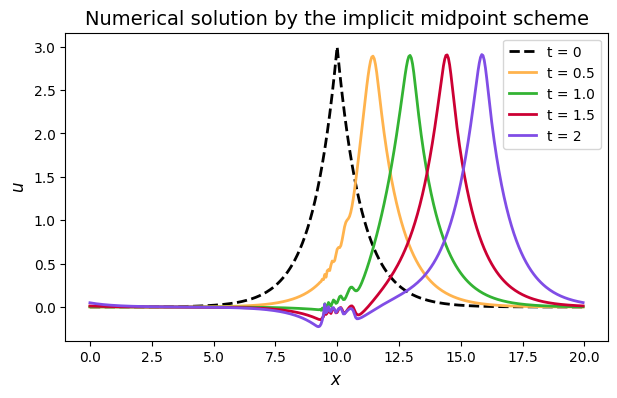

In [18]:
fig = plt.figure(figsize=(7,4))
lw = 2
plt.plot(x, u[0,:], 'k--', linewidth=lw, label='t = 0')
plt.plot(x, u[int(N/4),:], color = colors[1], linewidth=lw, label=f't = {1/4*t_max}')  
plt.plot(x, u[int(N/2),:], color = colors[2], linewidth=lw, label=f't = {1/2*t_max}')  
plt.plot(x, u[int(3*N/4),:], color = colors[3], linewidth=lw, label=f't = {3/4*t_max}')  
plt.plot(x, u[-1,:], color = colors[4], linewidth=lw, label=f't = {t_max}')  
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$u$', fontsize=12)
plt.title('Numerical solution by the implicit midpoint scheme', fontsize=14)
plt.legend()
plt.show()

## A more advanced problem

Let us then consider also problems that do not have an analytic solution, e.g. a system with two waves:

In [19]:
def initial_condition_ch(x=np.linspace(0,20.-.2,100)):
    M = x.size
    P = int((x[-1]-x[0])*M/(M-1))
    c1, c2 = 3., 2.
    d1, d2 = .25, .5
    u0 = 0
    u0 += c1 / np.cosh(P/2) * np.cosh(np.abs((x+P/2-P*d1) % P - P/2)-P/2)
    u0 += c2 / np.cosh(P/2) * np.cosh(np.abs((x+P/2-P*d2) % P - P/2)-P/2)
    u0 = np.concatenate([u0[M:], u0[:M]], axis=-1)
    return u0

Define the spatial grid:

In [20]:
P = 40
M = 400 # increase or decrease M to see how the approximation gets better/worse
x, dx = grid(P, M)
D1, D2 = difference_matrices(P,M)
D1f, D1b = difference_matrices_fb(P,M)
I = np.eye(M)

In [21]:
u0 = initial_condition_ch(x)

And let us also consider the case of an external force acting on the system:

In [22]:
# g = lambda x, t: 3*np.sin(2*np.pi*t)
g = lambda x, t: np.sin(2*np.pi/P*x)*np.zeros_like(t)
#g = lambda x, t: 3*np.sin(2*np.pi/P*x)*np.sin(2*np.pi*t)
f = lambda u, t: np.linalg.solve(I-D2, -np.matmul(D1, 1.5*u**2 + .5*np.matmul(D1f,u)**2
                                  - np.matmul(D1b,u*np.matmul(D1f,u)) + kappa*u) + g(x, t))
Df = lambda u: np.linalg.solve(I-D2, -np.matmul(D1, 3*np.diag(u) + np.matmul(D1f,np.diag(np.matmul(D1f,u)))
                 - np.matmul(D1b, np.matmul(D1f,np.diag(u)) + np.matmul(np.diag(u),D1f)) + kappa*I))

Define the temporal grid:

In [23]:
t_max = 4
N = 400
t, dt = grid(t_max, N)

Integrate with the implicit midpoint method:

In [24]:
u = np.zeros([t.shape[0], u0.shape[-1]])
u[0, :] = u0
for i, t_step in enumerate(t[:-1]):
    u[i+1,:] = midpoint_method(u[i,:], u[i,:], t[i], f, Df, dt, M, 1e-12, 5)

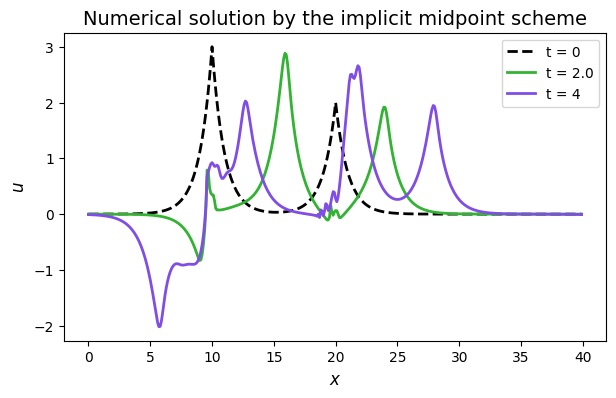

In [25]:
fig = plt.figure(figsize=(7,4))
lw = 2
plt.plot(x, u[0,:], 'k--', linewidth=lw, label='t = 0')
#plt.plot(x, u[int(N/4),:], color = colors[1], linewidth=lw, label=f't = {1/4*t_max}')  
plt.plot(x, u[int(N/2),:], color = colors[2], linewidth=lw, label=f't = {1/2*t_max}')  
#plt.plot(x, u[int(3*N/4),:], color = colors[3], linewidth=lw, label=f't = {3/4*t_max}')  
plt.plot(x, u[-1,:], color = colors[4], linewidth=lw, label=f't = {t_max}')  
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$u$', fontsize=12)
plt.title('Numerical solution by the implicit midpoint scheme', fontsize=14)
plt.legend()
plt.show()